In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# The Directed Polymer Model in (1+1)d

<hr>

## Introduction


We consider the **directed polymer in a random medium** on a discrete lattice with coordinates $(x, t)$:
<figure>
<center>
<img src='polymer.png' width="800"/>
</center>
</figure>


- At each lattice site $(x, t)$ there is a **disorder potential** $V_{x,t}$,  
  modeled as independent random variables drawn from a normal distribution.  

- A **polymer configuration** is a directed path $x(t)$ that starts at the origin: $ x(0) = 0$,   $ t = 0 $

- To each configuration $x(t)$ of length $T$ ("time direction") we assign an **energy**:
  $$ E[x(t)] = \sum_{t=0}^{T} V_{x(t),t}$$  

- The **Boltzmann weight** of a configuration is then:
  $$
  P[x(t)] \;=\; \frac{1}{Z} \, \exp\big( - \beta \, E[x(t)] \big),
  $$
  where $\beta$ is the inverse temperature, and $Z$ is the partition function that ensures normalization.



In this model we will study:
- **Ground states** (minimum-energy paths),
- **Thermal fluctuations** of polymers at finite temperature,
- **Scaling behavior** and universality properties.




**Questions:**
1. How many polymers you can draw from $0$ to $t$?
2. Select a polymer at random. How $x_t$ scales with $t$?
3. How many polymers you can draw from $(0,0)$ to $(t,x_t)$, with $x_t$ given?

# 1. Ground State — Dijkstra Algorithm
---
In general, **Dijkstra’s algorithm** is used to find the shortest path between nodes in a graph.  
For example, it is commonly employed in **GPS navigation systems** to find the optimal route between two locations.  


Here, we adapt this idea to the directed polymer: each lattice site $(t, x)$ is a node, and the energy of the polymer corresponds to the path weight. 
To find the ground state energy of the polymer, we can use a **dynamic programming approach** based on the following recursion relation:

$$
E(t', x) = V_{t',x} \;+\; \min \Big\{ \, E(t'-1, x-1), \; E(t'-1, x+1) \, \Big\}.
$$

This relation expresses the fact that the minimal energy to reach site $(t', x)$ is equal to the local potential $V_{t',x}$ plus the minimum energy of its two possible predecessors at the previous time step.


**Question**: How many operations are needed to implement this recursion relation up to time $T$?  


## Notation and Array Shapes

- **Polymer length**:  
  `T` = total number of time steps.  

- **Disorder potential**:  
  `V[t, x]` = potential at time `t` and position `x`.  
  - Shape: `(T + 1, 2*T + 1)`  
  - Time index: `t ∈ [0, T]`  
  - Spatial coordinate: `x ∈ [-T, T]`, shifted to array indices `[0, 2*T]`.  

- **Ground-state energy**:  
  `E[x]` = minimal energy at final time `t = T` and position `x`.  
  - Shape: `(2*T + 1,)`  
  - Uses the same spatial indexing convention as `V`.  

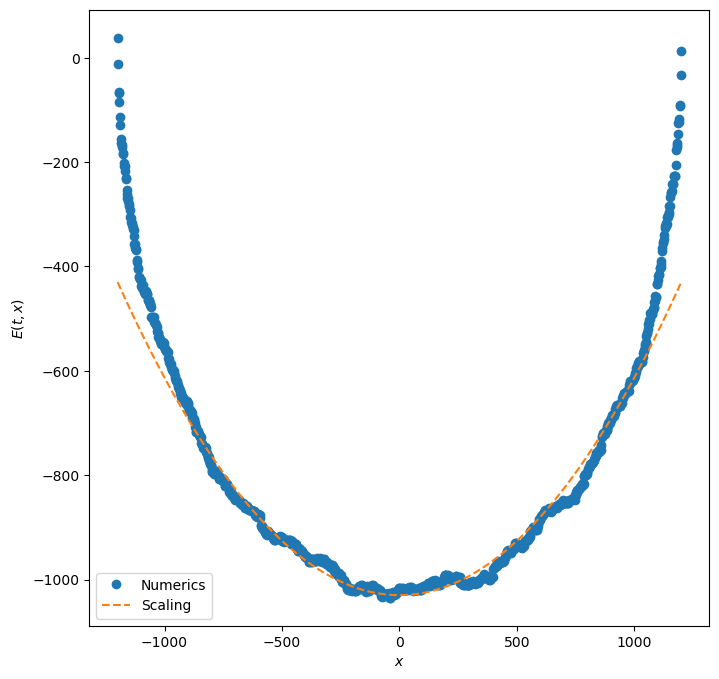

In [2]:
def compute_ground_state_energy(T: int, V: np.ndarray) -> np.ndarray:
    """
    Compute the ground state energy of a directed polymer in a random potential.

    Parameters
    ----------
    T : int
        Total number of time steps of the polymer.
    V : np.ndarray, shape (T+1, 2*T + 1)
        Random potential energy landscape where V[t, x] corresponds to
        the energy at time t and position x - T (so that x ∈ [-T, T]).

    Returns
    -------
    E : np.ndarray, shape (2*T+1,)
        Ground state energy at final time T.
    """

    E = np.full(2*T + 1, np.inf)
    E[T] = V[0,T]  # initial condition: E(0, x=0) = V_00

    # propagation step
    for time in range(1,T+1):

        left, right = np.roll(E, 1), np.roll(E,-1)
        left[0], right[-1] = np.inf, np.inf

        E = np.minimum(left, right) + V[time, ::]

    return E

T = 1200


np.random.seed(1234)
# initialize disorder
V = np.random.normal(0, 1, size=(T+1, 2 * T + 1))
# compute the ground state energy
E = compute_ground_state_energy(T,V)


plt.figure(figsize=(8, 8))
x = np.arange(-T, T+1)

plt.plot(x, E, "o", label = 'Numerics')

plt.plot(x, x**2 / (2*T) - 1030, "--", label = 'Scaling')

plt.xlabel(r"$x$")
plt.ylabel(r"$E(t,x)$")
plt.legend()

By storing both the minimum energy to reach each site and the direction of the optimal move, we can reconstruct the ground-state configuration of the polymer.

In [3]:
from typing import Tuple

def find_ground_state_configuration(T: int, V: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the ground state energy and the corresponding configuration (via
    directions) of a directed polymer in a random potential.

    Parameters
    ----------
    T : int
        Total number of time steps of the polymer.
    V : np.ndarray, shape (T+1, 2*T+1)
        Random potential energy landscape where V[t, x] corresponds to
        the energy at time t and position x - T (so that x ∈ [-T, T]).

    Returns
    -------
    E : np.ndarray, shape (2*T+1,)
        Ground state energy at final time T as a function of position x ∈ [-T, T].

    directions : np.ndarray, shape (T+1, 2*T+1)
        Direction of optimal move at each (time, position).
        +1 indicates moving right (x+1), -1 indicates moving left (x-1).
    """
    X = 2 * T + 1

    # initialization
    E = np.full(X, np.inf)
    E[T] = V[0,T]
    directions = np.zeros((T + 1, X))


    for time in range(1,T+1):
        left, right = np.roll(E, 1), np.roll(E,-1)
        left[0], right[-1] = np.inf, np.inf

        E = np.minimum(left, right) + V[time, ::]
        directions[time, ::] = (left > right) * 2 - 1


    return E, directions


def get_polymer(T: int, x0: int, directions: np.ndarray) -> np.ndarray:
    """
    Reconstruct the ground state polymer configuration from the directions.

    Parameters
    ----------
    T : int
        Total number of time steps of the polymer.
    x0 : int
        Final position (at time T) corresponding to the ground state energy minimum.
    directions : np.ndarray, shape (T+1, 2*T+1)
        Directions computed by `find_ground_state_configuration`, where
        directions[time, x] is +1 or -1 indicating the optimal move.

    Returns
    -------
    polymer : np.ndarray, shape (T+1,)
        Sequence of positions (as array indices) visited by the polymer
        from time 0 to time T (ordered in increasing time).
    """
    X = directions.shape[1]
    polymer = np.zeros(T + 1, dtype=int)
    polymer[0] = x0 + T

    for time in range(1, T + 1):
        polymer[time] = polymer[time - 1] + directions[T + 1 - time, polymer[time - 1]]


    return polymer[::-1]

Text(0, 0.5, '$t$')

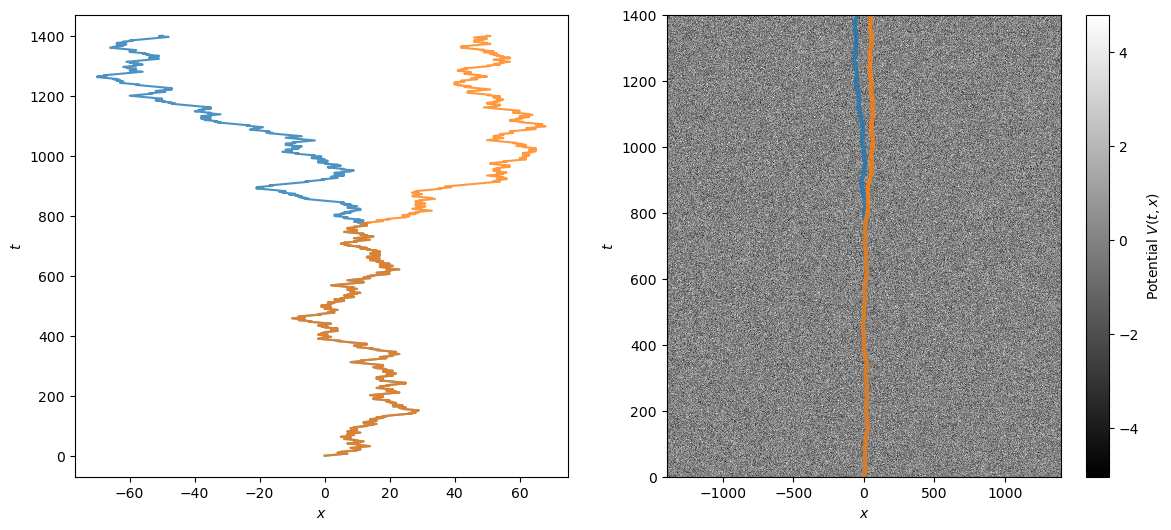

In [4]:
T = 1400

np.random.seed(0)
V = np.random.normal(0, 1, size=(T+1, 2*T+ 1))
E, directions = find_ground_state_configuration(T,V)



fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot potential as a colored grid of squares
# Define coordinate grids
x = np.arange(-T, T + 1)
time = np.arange(0, T + 1)
X_grid, T_grid = np.meshgrid(x, time)

pcm = axs[1].pcolormesh(X_grid, T_grid, V, shading='auto', cmap = 'gray')
fig.colorbar(pcm, ax=axs[1], label='Potential $V(t, x)$')

for x0 in [-50, 50]:
    polymer = get_polymer(T, x0, directions)
    axs[0].plot(polymer-T, np.arange(0,T+1), alpha = .8)
    axs[1].plot(polymer-T, np.arange(0,T+1), alpha = .8, linewidth = 3)

axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$t$')

axs[1].set_xlabel(r'$x$')
axs[1].set_ylabel(r'$t$')

**Questions:**
1. Is it possible to find the polymer with the energy closest to zero?
2. Is it possible to generalize the algorithm to finite temperatures?

# 2. Partition Function

---

At finite temperature, the partition function $Z(t, x)$ at time $t$ and position $x$ satisfies a recursion relation analogous to that of the ground-state energy:

$$ Z(t', x) = e^{-\beta \, V_{t',x}} \; \Big( Z(t'-1, x-1) + Z(t'-1, x+1) \Big), $$

This recursion allows us to compute the partition function using a slight modification of the Dijkstra algorithm for the ground-state energy.

For numerical stability, the partition function is normalized at each time step, and the overall normalization is tracked separately.  
The logarithm of the partition function can then be reconstructed to obtain $\log Z(t, x)$ for all positions $x$ at the final time $T$.

In [5]:
def compute_partition_function(T,beta, V):
    """
    Compute the logarithm of the partition function Z(t, x) for all positions x
    at the time T.
    NB. For better numerical stability -- normalize the partition function at
    each time step and keep track of the overall normalization.

    Parameters
    ----------
    T : int
        Total number of time steps of the polymer.
    beta : float
        Inverse temperature.
    V : np.ndarray, shape (T+1, 2*T+1)
        Random potential energy landscape where V[t, x] corresponds to
        the energy at time t and position x - T (so that x ∈ [-T, T]).

    Returns
    -------
    logZ : np.ndarray, shape (2*T+1,)
        Log of the partition function at the time T for all  x in [-T, T]
    """
    # initialize partition function  array
    Z = np.zeros(2 * T + 1 )
    Z[T] = np.exp( - beta * V[0,T] )
    log_Z_normalization = 0

    # propagation step
    for time in range(1,T+1):
        left, right = np.roll(Z, 1), np.roll(Z,-1)
        left[0], right[-1] = 0, 0
        Z = (left + right) * np.exp( - beta * V[time, ::])
        Z_max = np.max(Z)
        Z = Z/Z_max
        log_Z_normalization += np.log(Z_max)

    logZ = np.log(Z) + log_Z_normalization
    return logZ

np.random.seed(1234)


T = 500
X = 2 * T + 1  # Range for x in [-T, T]
beta = .4

# initialize disorder
V = np.random.normal(0, 1, size=(T+1, 2 * T + 1))
# compute the partition function
logZ = compute_partition_function(T,beta, V)

/var/folders/2z/r6g87k_s3lj8f7t0wwxd1fl00000gp/T/ipykernel_8439/3619986178.py:37: RuntimeWarning: divide by zero encountered in log
  logZ = np.log(Z) + log_Z_normalization


At $\beta = 0$, the Boltzmann weight is uniform for all configurations, so the partition function $Z(t, x)$ simply counts the number of directed paths from $(0,0)$ to $(t, x)$.  This number is given by the **binomial coefficient**:

$$ Z(t, x) = \binom{t}{\frac{t + x}{2}}. $$

This provides a simple consistency check for the numerical implementation of the partition function.

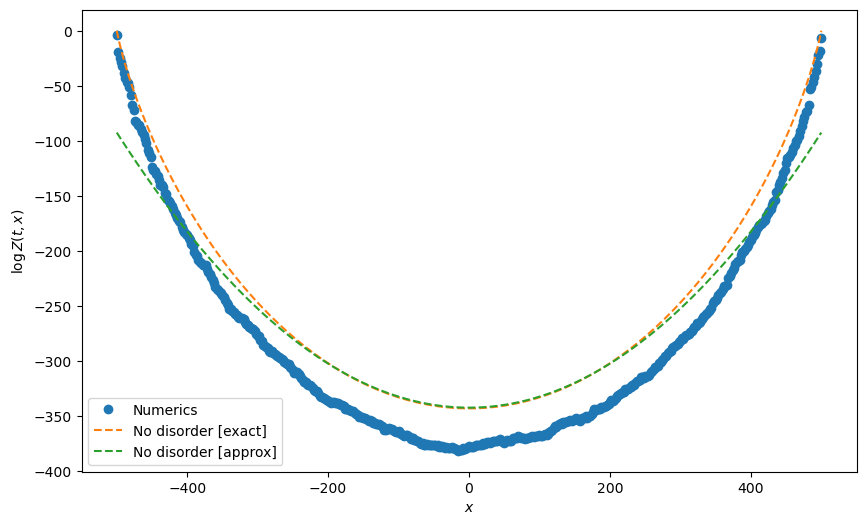

In [6]:
from scipy.special import binom

x = np.arange(-T, T+1)
logZ0_exact =  - np.log( binom(T, (T+x) / 2) )
logZ0_approx = x**2 / (2 * T) + .5 * np.log(2 * np.pi * T) - T * np.log(2)


plt.figure(figsize=(10, 6))
plt.plot(x, - logZ, "o", label = 'Numerics')
plt.plot(x, logZ0_exact, "--", label = 'No disorder [exact]')
plt.plot(x, logZ0_approx, "--", label = 'No disorder [approx]')
plt.xlabel(r"$x$")
plt.ylabel(r"$\log Z(t,x)$")
plt.legend()

# 3. Thermodynamic properties
---


Now we compute and compare the **annealed** and **quenched** free energies per unit time for the directed polymer model at different values of $\beta$.

- The **annealed free energy** is obtained by averaging the partition function over disorder realizations **before** taking the logarithm:

$$
f^\mathrm{annealed} = -\frac{1}{\beta T} \, \log \overline{Z},
$$

where $\overline{Z}$ denotes the average over disorder.

- The **quenched free energy** is obtained by averaging the logarithm of the partition function **after** computing it for each disorder realization:

$$
f^\mathrm{quenched} = -\frac{1}{\beta T} \, \overline{\log Z}.
$$

To estimate these quantities, we perform multiple disorder realizations and compute the corresponding free energies as a function of $\beta$.

**Question:** Which of the two free energies is smaller, and why?

  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/2z/r6g87k_s3lj8f7t0wwxd1fl00000gp/T/ipykernel_8439/3619986178.py:37: RuntimeWarning: divide by zero encountered in log
  logZ = np.log(Z) + log_Z_normalization
/var/folders/2z/r6g87k_s3lj8f7t0wwxd1fl00000gp/T/ipykernel_8439/834747500.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  annealed += [- (1/beta) * (1/T) * np.log(np.mean(Z_data))]
/var/folders/2z/r6g87k_s3lj8f7t0wwxd1fl00000gp/T/ipykernel_8439/834747500.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  quenched += [- (1/beta) * (1/T) * np.mean(np.log(Z_data))]


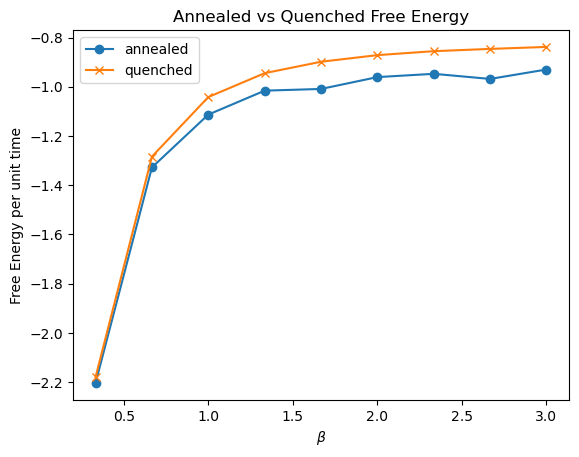

In [7]:
T = 200
beta_values = np.linspace(0, 3, 10)
num_realizations = 1000

annealed = []
quenched = []

for beta in tqdm(beta_values):
    Z_data = np.zeros(num_realizations)
    for i in range(num_realizations):
        V = np.random.normal(0, 1, size=(T+1, 2 * T + 1))
        logZ = compute_partition_function(T, beta, V)
        Z_data[i] = np.exp(logZ[T])

    annealed += [- (1/beta) * (1/T) * np.log(np.mean(Z_data))]
    quenched += [- (1/beta) * (1/T) * np.mean(np.log(Z_data))]

plt.plot(beta_values, annealed, label='annealed', marker='o')
plt.plot(beta_values, quenched, label='quenched', marker='x')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Free Energy per unit time')
plt.title('Annealed vs Quenched Free Energy')
plt.legend()

# 4. Scaling exponents
---

In the directed polymer model, the **ground-state energy** grows linearly with time in the large-$t$ limit, with subleading fluctuations characterized by a scaling exponent. Specifically, we expect:

$$ E_{\rm min}(t) \;\approx\; c_\infty \, t \;+\; b_\infty \, t^{\theta} \, \chi, $$

where:

- $c_\infty$ and $b_\infty$ are model-dependent constants,  
- $\theta$ is the **energy fluctuation exponent**,  
- $\chi$ is a random variable capturing the scaled energy fluctuations.

Similarly, the **transverse displacement** of the ground-state polymer scales as:

$$
x_*(t) \;\approx\; a_\infty \, t^\zeta \, \tilde{\chi},
$$

where:

- $a_\infty$ is a constant,  
- $\zeta$ is the **roughness exponent**,  
- $\tilde{\chi}$ is a random variable describing the scaled transverse fluctuations.

Below we estimate the exponents $\theta$ and $\zeta$ from the numerical data. Recall that for the directed polymer we must have
$$
    \theta = 2\zeta - 1
$$

In [8]:
def get_statistics(T: int, V: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the minimum energy and the displacement of the polymer in the ground state
    as a function of time, with free boundary conditions.

    Parameters
    ----------
    T : int
        Total number of time steps of the polymer.
    V : np.ndarray, shape (T+1, 2*T+1)
        Random potential energy landscape where V[t, x] corresponds to
        the energy at time t and position x - T (so that x ∈ [-T, T]).

    Returns
    -------
    E_min : np.ndarray, shape (T+1,)
        Minimum energy of the polymer at each time step.

    displacement : np.ndarray, shape (T+1,)
        Displacement of the minimum energy configuration relative to the origin at each time step.
    """
    E = np.full(X, np.inf)
    E[T] = V[0,T]  # initial condition: E(0, x=0) = V_00

    # propagation step
    E_min = np.zeros(T+1)
    displacement = np.zeros(T+1)
    E_min[0], displacement[0] = V[0,T], 0

    for time in range(1,T+1):

        left, right = np.roll(E, 1), np.roll(E,-1)
        left[0], right[-1] = np.inf, np.inf

        E = np.minimum(left, right) + V[time, ::]

        min_idx = np.argmin(E)
        E_min[time] = E[min_idx]
        displacement[time] = min_idx - T

    return E_min, displacement

# initialize disorder
np.random.seed(1234)

T = 10000
X = 2 * T + 1  # Range for x in [-T, T]

V = np.random.normal(0, 1, size=(T+1, X))
Emin, displacement = get_statistics(T, V)


In [9]:
T = 1000
X = 2 * T + 1
num_realizations = 1000

# Arrays to store results
all_Emin = np.zeros((num_realizations, T + 1))
all_displacement = np.zeros((num_realizations, T + 1), dtype=int)

np.random.seed(10)
for i in tqdm(range(num_realizations)):
    # Generate disorder
    V = np.random.normal(0, 1, size=(T + 1, X))

    # Compute minimal energy and corresponding displacement
    all_Emin[i], all_displacement[i] = get_statistics(T, V)

  0%|          | 0/1000 [00:00<?, ?it/s]

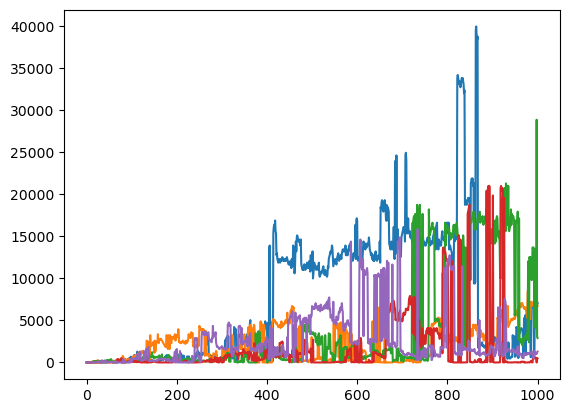

In [10]:
for i in range(min(num_realizations,5)):
    displacement = all_displacement[i]
    plt.plot(displacement ** 2)

Estimated exponent 𝜁: 0.667


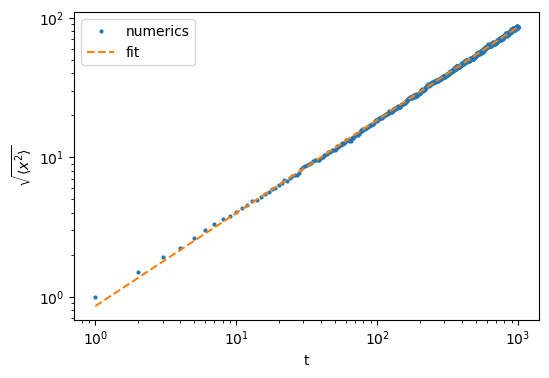

In [11]:
#  Observable: mean squared displacement
y = np.sqrt(np.mean(all_displacement**2, axis=0))
t = np.arange(1, T+1)  # avoid t=0
y = y[1:]

# Linear regression in log-log scale
log_t = np.log(t)
log_y = np.log(y)
slope, intercept = np.polyfit(log_t, log_y, 1)

print(f"Estimated exponent 𝜁: {slope:.3f}")

# Plot
plt.figure(figsize=(6,4))
plt.plot(t, y, "o", markersize=2, label='numerics')
plt.plot(t, np.exp(intercept) * t**slope, '--', label=r'fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('t')
plt.ylabel(r'$\sqrt{\langle x^2 \rangle}$')
plt.legend()
plt.show()

Estimated exponent 𝜃: 0.328


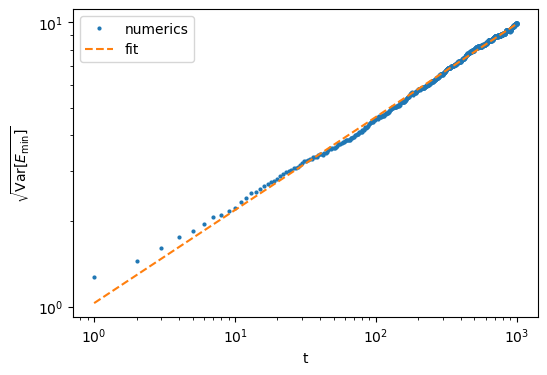

In [12]:
# Observable: standard deviation of E_min
y = np.sqrt(np.var(all_Emin, axis=0))
t = np.arange(1, T+1)
y = y[1:]

# Linear regression in log-log scale
log_t = np.log(t)
log_y = np.log(y)
slope, intercept = np.polyfit(log_t, log_y, 1)

print(f"Estimated exponent 𝜃: {slope:.3f}")

# Plot
plt.figure(figsize=(6,4))
plt.plot(t, y, "o", markersize=2, label='numerics')
plt.plot(t, np.exp(intercept) * t**slope, '--', label='fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('t')
plt.ylabel(r'$\sqrt{\mathrm{Var}[E_\mathrm{min}]}$')
plt.legend()
plt.show()

References

* Kardar, M. (2007). Statistical physics of fields. Cambridge University Press. Chapter 10